In [1]:
import samna
print(f'Samna version {samna.__version__}')

Samna version 0.39.9.0


In [2]:
import samna

# Open the device and connect to the power monitor.
board = samna.device.open_device("XyloAudio3TestBoard")
power_monitor = board.get_power_monitor()
sink_pm = samna.graph.sink_from(power_monitor.get_source_node())
stopwatch = board.get_stop_watch()
io = board.get_io_module()

config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
clock_frequencies = [0, 0.012207031, 0.024414063, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50]
write_config = [0, 4095, 2047, 1023, 511, 255, 127, 63, 31, 15, 7, 3, 1, 0]

clock_frequencies = [6.25, 12.5, 25, 50]
power_consumption = []

for clock in clock_frequencies:
    # print(clock)
    config.main_clock_frequency = int(clock * 1000000)
    board.reset_board_soft(config)

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    # print(avgs)
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    # print(power)
    print(f'Clock:\t\t{clock} MHz\n io:\t\t{power[0]:.1f} mW \t\t AFE core:\t{power[1]:.1f} mW\t\t SNN core logic:\t{power[2]:.1f} mW')

IOStream.flush timed out


Clock:		6.25 MHz
 io:		0.0 mW 		 AFE core:	0.0 mW		 SNN core logic:	0.3 mW
Clock:		12.5 MHz
 io:		0.1 mW 		 AFE core:	0.0 mW		 SNN core logic:	0.5 mW
Clock:		25 MHz
 io:		0.1 mW 		 AFE core:	0.0 mW		 SNN core logic:	0.8 mW
Clock:		50 MHz
 io:		0.2 mW 		 AFE core:	0.0 mW		 SNN core logic:	1.4 mW


In [3]:
for power in power_consumption:
    print(112.5/2.5 * 1000)

45000.0
45000.0
45000.0
45000.0


# Real-time Steps

In real-time mode, the FPGA lets Xylo run freely and only performs readout after receiving a timestep done interrupt.
This means sending input to Xylo from the FPGA is not supported in real-time mode.  Instead, the switches on the PCB must be configured such that Xylo receives input from the microphones on the PCB.


In [4]:
ts_duration   = 10*1e-3; # in second
main_clk_freq = 50*1e6 # in Hz
tr_wrap       = int(ts_duration*main_clk_freq)
print(tr_wrap)

# 0: input for Xylo, 1: Xylo output
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

500000


## Example with Rockpool

In [5]:
import warnings
warnings.filterwarnings("ignore")

import rockpool
print(f'Rockpool version {rockpool.__version__}')
import samna
print(f'Samna version {samna.__version__}')
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper, XyloMonitor, XyloSamna

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np

# find_xylo_hdks() directly calls the Samna device finder and opens all available devices.
# When Samna opens a device, it will perform actions on the board. Such as, powering on the chip, resetting it,
# applying a default configuration, and configuring the FPGA for default operation.

hdks, modules, versions = find_xylo_hdks()
print(hdks, modules, versions)

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xylo_node = xylo

Rockpool version 2.8.8.dev
Samna version 0.39.9.0
The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x7b4efeb3a3b0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


## Build a model and map it to hardware

In [6]:
# simple model to test

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 16)),
    LIF(16),
)

print(net)

# net[0].weight *= 0.05
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

ModSequential  with shape (16, 16) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 16)
    LIF '3_LIF' with shape (16, 16)
}


## Set up Samna graphs and configuration

In [7]:
# create xylo monitor
dt = 0.01
dt_ms = dt * 1000

config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
# config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=dt_ms, main_clk_freq_in_mhz=12.5, debug=1)
# config.debug.always_update_omp_stat                          = True
# config.input_source                                          = samna.xyloAudio3.InputSource.PdmEvents
# config.digital_frontend.filter_bank.dn_enable                = False
# config.digital_frontend.filter_bank.use_global_iaf_threshold = False
# config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
# config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
# config.debug.sdm_clock_ratio                                 = 24

# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, main_clk_rate =50, 
    config=config, power_frequency=100,
    dt = dt,
    output_mode='Spike')


In [12]:
config

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.RealTime, input_source=InputSource.DigitalMicrophone, synapse2_enable=0, bias_enable=1, time_resolution_wrap=500000, output_counter_wrap=0, enable_hibernation_mode=0, hibernation_mode_time_resolution_wrap=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -9 -104 -88 115 -7 -122 8 -109 100 69 -46 -26 -24 -120 8 64 90 49 32 18 -34 47 35 -12 114 -32 -39 -66 -35 71 -126 103 29 -34 -63 -47 75 52 -54 80 -120 33 102 -112 75 -14 112 -13 74 -55 42 29 -92 58 -93 8 58 -2 5 127 99 83 -63 -98 -127 -1 -72 2 -76 127 -121 70 94 26 -60 82 -20 33 32 -26 5 -79 2 68 -61 75 -127 98 6 12 -89 65 45 -39 -8 -13 110 43 127 9 55 28 29 -70 -74 -113 105 -47 46 16 4 -85 -83 -61 -3 -127 -29 107 45 -79 55 -27 -36 -46 31 -78 -76 -63 -58 52 -23 21 119 -18 -3 -14 83 -115 -117 -107 107 11 -108 -79 -72 -49 127 92 -104 71 -3 48 -11 -88 -127 -8 123 71 114 127 28 -58 104 -103 -81 1 120 49 3 29 17 122 -87 37 34 98 -29 -72 115

In [8]:
import samna
print(f"samna version: {samna.__version__}")
import time

# set device configuration
ioc = xylo_node.get_io_control_module()
io = xylo_node.get_io_module()
model = xylo_node.get_model()


def read_register(addr):
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address = addr)])
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data

ctrl1 = 0x0001
ctrl2 = 0x0002
ctrl3 = 0x0003
tr_wrap = 0x0004
hm_tr_wrap = 0x0005
clk_ctrl = 0x0006
clk_div = 0x0007
pwr_ctrl1 = 0x0008
pwr_ctrl2 = 0x0009
pwr_ctrl3 = 0x000A
pwr_ctrl4 = 0x000B
pad_ctrl = 0x000C
ie1 = 0x000E
ie2 = 0x000F
out_ctrl = 0x0011
monsel = 0x0166
mon_grp_sel = 0x0167
dbg_ctrl1 = 0x0168
dbg_stat1 = 0x0171
dfe_ctrl = 0x001B
ivgen = 0x0015
ivgen2 = 0x0016
ivgen3 = 0x0017
ivgen4 = 0x0018
ivgen5 = 0x0019
ivgen6 = 0x001A
adctest = 0x016E

# create access to xylo input/output
source = samna.graph.source_to(model.get_sink_node())
sink   = samna.graph.sink_from(model.get_source_node())


print("\n# ======= read important registers =======\n")

print(f"adctest       : 0x{format(read_register(adctest),'_X')}")
print(f"ivgen       : 0x{format(read_register(ivgen),'_X')} vs 7331_85F8")
print(f"ivgen2       : 0x{format(read_register(ivgen2),'_X')} vs 1323_1107")
print(f"ivgen3       : 0x{format(read_register(ivgen3),'_X')} vs 1112_1003")
print(f"ivgen4       : 0x{format(read_register(ivgen4),'_X')} vs 0000_1210")
print(f"ivgen5       : 0x{format(read_register(ivgen5),'_X')} vs 0000_0C07")
print(f"ivgen6       : 0x{format(read_register(ivgen6),'_X')} vs 0000_0031")
# # ctrl[1-3]
print(f"ctrl1       : 0x{format(read_register(ctrl1),'_X')} vs 0x143_011C")
print(f"ctrl2       : 0x{format(read_register(ctrl2),'_X')} vs 0x9_0902")
print(f"ctrl3       : 0x{format(read_register(ctrl3),'_X')} vs 0x901")
print()
# *_wrap
print(f"tr_wrap     : 0x{format(read_register(tr_wrap),'_X')} vs 0x2FA_F080")
print(f"hm_tr_wrap  : 0x{format(read_register(hm_tr_wrap),'_X')} vs 0x0")
print()
# clk_*
print(f"clk_ctrl    : 0x{format(read_register(clk_ctrl),'_X')} vs 0x11")
print(f"clk_div     : 0x{format(read_register(clk_div),'_X')} vs 0x18_0000")
print()
# pwr_ctrl[1-4]
print(f"pwr_ctrl1   : 0x{format(read_register(pwr_ctrl1),'_X')} vs 0x33_00FF")
print(f"pwr_ctrl2   : 0x{format(read_register(pwr_ctrl2),'_X')} vs 0x3_0001")
print(f"pwr_ctrl3   : 0x{format(read_register(pwr_ctrl3),'_X')} vs 0xFFFF_FFFF")
print(f"pwr_ctrl4   : 0x{format(read_register(pwr_ctrl4),'_X')} vs 0xFFFF_0001")
print()
# misc
print(f"pad_ctrl    : 0x{format(read_register(pad_ctrl),'_X')} vs 0x0")
print(f"ie1         : 0x{format(read_register(ie1),'_X')} vs 0x0")
print(f"ie2         : 0x{format(read_register(ie2),'_X')} vs 0x1")
print(f"out_ctrl    : 0x{format(read_register(out_ctrl),'_X')} vs 0x70")
print()
# debug regs
print(f"monsel      : 0x{format(read_register(monsel),'_X')} vs 0x0")
print(f"mon_grp_sel : 0x{format(read_register(mon_grp_sel),'_X')} vs 0x1F1F_0773")
print(f"dbg_ctrl1   : 0x{format(read_register(dbg_ctrl1),'_X')} vs 0x0")
print(f"dbg_stat1   : 0x{format(read_register(dbg_stat1),'_X')} vs 0x0")
print(f"dfe_ctrl   : 0x{format(read_register(dfe_ctrl),'_X')} vs 0x510")
print()

samna version: 0.39.9.0

# ======= read important registers =======

adctest       : 0x0
ivgen       : 0x371_2457 vs 7331_85F8
ivgen2       : 0x3323_1103 vs 1323_1107
ivgen3       : 0x1112_1000 vs 1112_1003
ivgen4       : 0x200 vs 0000_1210
ivgen5       : 0xC00 vs 0000_0C07
ivgen6       : 0x0 vs 0000_0031
ctrl1       : 0x140_000C vs 0x143_011C
ctrl2       : 0x3E_3E0F vs 0x9_0902
ctrl3       : 0x3E0F vs 0x901

tr_wrap     : 0x7_A120 vs 0x2FA_F080
hm_tr_wrap  : 0x0 vs 0x0

clk_ctrl    : 0x11 vs 0x11
clk_div     : 0xF_0000 vs 0x18_0000

pwr_ctrl1   : 0x30_00FF vs 0x33_00FF
pwr_ctrl2   : 0x1_0001 vs 0x3_0001
pwr_ctrl3   : 0x0 vs 0xFFFF_FFFF
pwr_ctrl4   : 0x0 vs 0xFFFF_0001

pad_ctrl    : 0x0 vs 0x0
ie1         : 0x0 vs 0x0
ie2         : 0x1 vs 0x1
out_ctrl    : 0x70 vs 0x70

monsel      : 0x0 vs 0x0
mon_grp_sel : 0x1F1F_0773 vs 0x1F1F_0773
dbg_ctrl1   : 0x0 vs 0x0
dbg_stat1   : 0x0 vs 0x0
dfe_ctrl   : 0x3FFF_0537 vs 0x510



## Start processing and collect events

* Send TriggerProcessing event from Samna with the desired time step
* Collect readout events in the BufferSink attached to the model source node

In [9]:
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl1, data=0x0)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl2, data=0x0)])
# io.write_config(0x0007, 3)



In [10]:
import numpy as np
N = 3 # in seconds

# io.write_config(0x0007, 3)

for i in range(10):
    out, _, rec = xylo_monitor.evolve(record=False, record_power=True, read_timeout=N)
    # print(out)
    print(rec)

print(len(rec['io_power']))

io_power = np.mean(rec['io_power'])
analog = np.mean(rec['analog_power'])
digital = np.mean(rec['digital_power'])


print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1000:.1f} mW\nAFE core:\t{analog * 1000:.1f} mW\nSNN core logic:\t{digital*1000:.1f} mW')

{'io_power': array([0.00061431, 0.00203069, 0.00205442, 0.00205574, 0.00203069,
       0.00203069, 0.00204949, 0.00204934, 0.00203682, 0.00201865,
       0.00204321, 0.00203696, 0.00204321, 0.00204321, 0.00204949,
       0.00203599, 0.00206201, 0.00205574, 0.00203591, 0.00202976,
       0.00204321, 0.00205574, 0.00204949, 0.00204949, 0.00203704,
       0.00204956, 0.00204214, 0.00202356, 0.00204321, 0.00204321,
       0.00205574, 0.00204949, 0.00203696, 0.00202427, 0.00202349,
       0.00203704, 0.00206829, 0.00204321, 0.00206216, 0.00204321,
       0.00201758, 0.00201851, 0.00204949, 0.00203054, 0.00203696,
       0.00204214, 0.00204321, 0.00204949, 0.00201104, 0.00201816,
       0.00206829, 0.00204329, 0.00205574, 0.00203054, 0.00204321,
       0.00203704, 0.00205574, 0.00204321, 0.00203096, 0.00205559,
       0.00204321, 0.00204321, 0.00206187, 0.00205574, 0.00204949,
       0.00204956, 0.00204949, 0.00201733, 0.00203682, 0.00204949,
       0.00201816, 0.00201724, 0.00204321, 0.0020

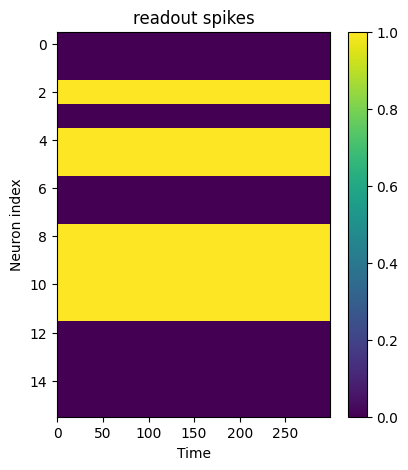

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()

In [13]:
out

[[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 1,